## Replication code for
# HANK on Speed: Robust Nonlinear Solutions using Automatic Differentiation
### Gregor Boehl

First, install the necessary packages. Do this either here (uncomment the cell below) or with your prefered package manager.

In [1]:
#!pip install econpizza
#!pip install grgrlib

The documentation for the EP package, which is featured by the paper, can be found [here](https://econpizza.readthedocs.io/en/stable/index.html).

Do some imports:

In [2]:
# imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import econpizza as ep
from grgrlib import pplot, grbar3d, figurator

# plotting setup
plt.rc('text', usetex=True)

# if you run this in a jupyter notebook:
%matplotlib inline

The YAML file which contains the two-asset HANK model is hosted as part of the example models for EP: https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank2.yml

All the models from the paper, and some others, are included: https://github.com/gboehl/econpizza/tree/master/econpizza/examples

That means, to parse the model, we can simply do:

In [3]:
file_name = ep.examples.hank2

# parsing
mod_dict0 = ep.parse(file_name)

# use a finer grid than the default
mod_dict0['distributions']['dist']['b']['n'] = 20
mod_dict0['distributions']['dist']['a']['n'] = 25

Solve for the steady state:

In [4]:
mod0 = ep.load(mod_dict0, raise_errors=True)
_ = mod0.solve_stst(tol=1e-8)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...adding endogenous log-grid for 'b' named 'b_grid'.
    ...adding endogenous log-grid for 'a' named 'a_grid'.
(load:) Parsing done.
    Iteration   1 | max. error 3.64e+01 | lapsed 6.8893
    Iteration   2 | max. error 1.68e-02 | lapsed 11.9689
    Iteration   3 | max. error 1.77e-06 | lapsed 16.9621
(solve_stst:) Steady state found (22.177s). The solution converged.


Create a second model instance for the redistributive steady state (the one with transfers):

In [5]:
mod_dict1 = ep.copy(mod_dict0)
mod_dict1['steady_state']['fixed_values']['transfers'] = mod0['stst']['y'] * .1
mod1 = ep.load(mod_dict1, raise_errors=True)
_ = mod1.solve_stst(tol=1e-8)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...adding endogenous log-grid for 'b' named 'b_grid'.
    ...adding endogenous log-grid for 'a' named 'a_grid'.
(load:) Parsing done.
    Iteration   1 | max. error 3.64e+01 | lapsed 7.6471
    Iteration   2 | max. error 4.91e+00 | lapsed 14.9097
    Iteration   3 | max. error 7.74e-02 | lapsed 22.3129
    Iteration   4 | max. error 7.30e-03 | lapsed 30.0295
    Iteration   5 | max. error 4.73e-07 | lapsed 37.7620
(solve_stst:) Steady state found (45.438s). The solution converged.


## Figure 1
Plot the steady state distribution without transfers.

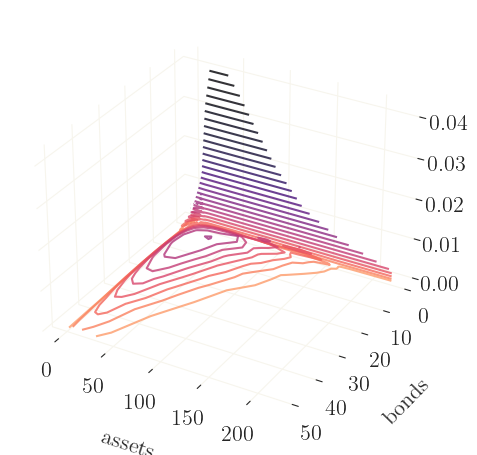

In [6]:
# get values
distSS = mod0['steady_state']['distributions'][0]
dec = mod0['steady_state']['decisions']
a_grid = mod0['context']['a_grid']
b_grid = mod0['context']['b_grid']

# some plotting setup
dataSS = distSS.sum(0)
n = 30
lgain = 3
lgain = 1.5
cgain = 2
levels = jnp.linspace(0,dataSS.max()**(1/lgain),n)**lgain
clist = plt.cm.magma(jnp.linspace(.00,.85**(1/cgain),n)**cgain)[::-1]

# do plotting
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour(*jnp.meshgrid(a_grid, b_grid), dataSS, colors=clist, alpha=.8, levels=levels)
ax.invert_yaxis()
ax.set_xlabel('assets', labelpad=15)
ax.set_ylabel('bonds', labelpad=15)
ax.set_zlabel('share', labelpad=15)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
fig.tight_layout()

## Figure 2
Next, calculate the transition dynamics between the two steady states. To speed things up, I here use a shorter simulation horizon (`200`) than in the paper (`400`). This barely makes any difference.

In [7]:
# set some inputs
x0 = mod0['stst'].copy()
dist0 = mod0['steady_state']['distributions']
pars = ep.copy(mod1['pars'])
pars['rho_r'] = .0

# horizon = 400 # works perfectly
# horizon = 300 is mostly okay
horizon = 200 # gives a good impression

# simulate
xst0, _ = mod1.find_path(init_state=x0.values(), init_dist=dist0, pars=pars, horizon=horizon)

(get_derivatives:) Derivatives calculation done (10.220s).
(get_jacobian:) Jacobian accumulation and decomposition done (8.942s).
    Iteration  1 | fev.  30 | error 6.91e+00 | inner 6.10e-01 | dampening 0.662
    Iteration  2 | fev.  42 | error 1.26e+00 | inner 2.28e-06 | dampening 1.000
    Iteration  3 | fev.  54 | error 3.46e-01 | inner 2.41e-06 | dampening 1.000
    Iteration  4 | fev.  65 | error 1.67e-01 | inner 8.83e-06 | dampening 1.000
    Iteration  5 | fev.  74 | error 4.72e-02 | inner 1.54e-06 | dampening 1.000
    Iteration  6 | fev.  78 | error 1.88e-03 | inner 9.75e-06 | dampening 1.000
    Iteration  7 | fev.  81 | error 3.00e-06 | inner 7.25e-08 | dampening 1.000
    Iteration  8 | fev.  84 | error 1.22e-07 | inner 1.13e-08 | dampening 1.000
    Iteration  9 | fev.  90 | error 6.38e-10 | inner 5.08e-11 | dampening 0.733 | lapsed 3.6894s
(find_path:) Stacking done (59.215s). The solution converged.


[None]

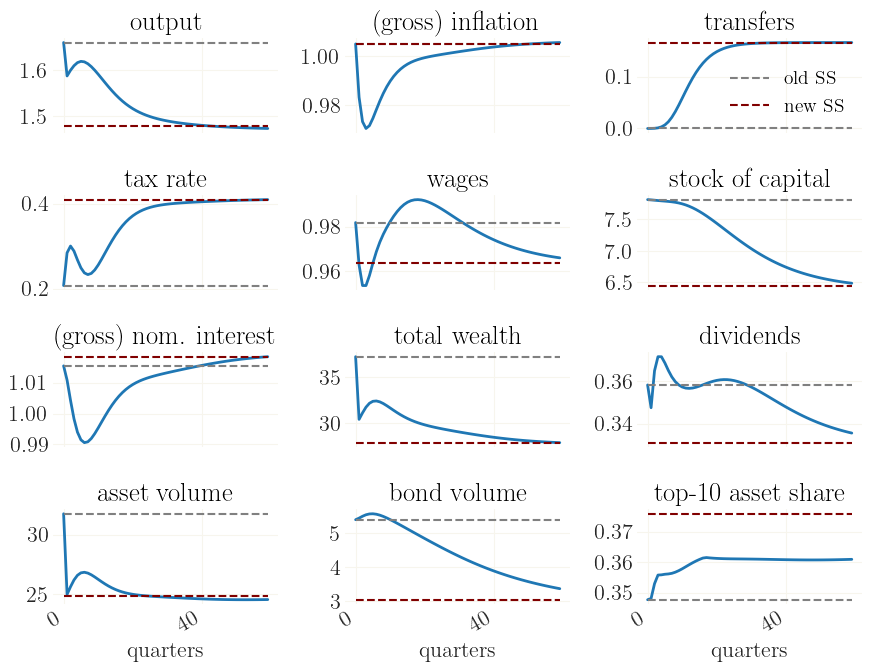

In [8]:
# choice of variables to plot
vlist = ['y', 'pi', 'transfers', 'tax', 'w', 'k', 'R', 'wealth', 'div', 'A', 'B', 'Top10A']
vprint = ['output', '(gross) inflation', 'transfers', 'tax rate', 'wages', 'stock of capital', '(gross) nom. interest', 'total wealth', 'dividends', 'asset volume', 'bond volume', 'top-10 asset share']
vinds = [mod0.variables.index(v) for v in vlist]

# plotting
figs, axs = figurator(4,3, figsize=(9,7))
alpha = 1
pplot(xst0[:60, vinds], labels=vprint, ax=axs, lw=2)
[axs[i].plot([mod0['stst'][v]]*60, ls='--', c='gray', alpha=alpha, label='old SS') for i,v in enumerate(vlist)]
[axs[i].plot([mod1['stst'][v]]*60, ls='--', c='maroon', alpha=alpha, label='new SS') for i,v in enumerate(vlist)]
[axs[i].set_xlabel('quarters') for i in (-1,-2,-3)]
axs[2].legend(framealpha=.0, fontsize=14)
[f.tight_layout() for f in figs]

## Figure 3
These are the associated transition dynamics (from a different view angle than in the paper).

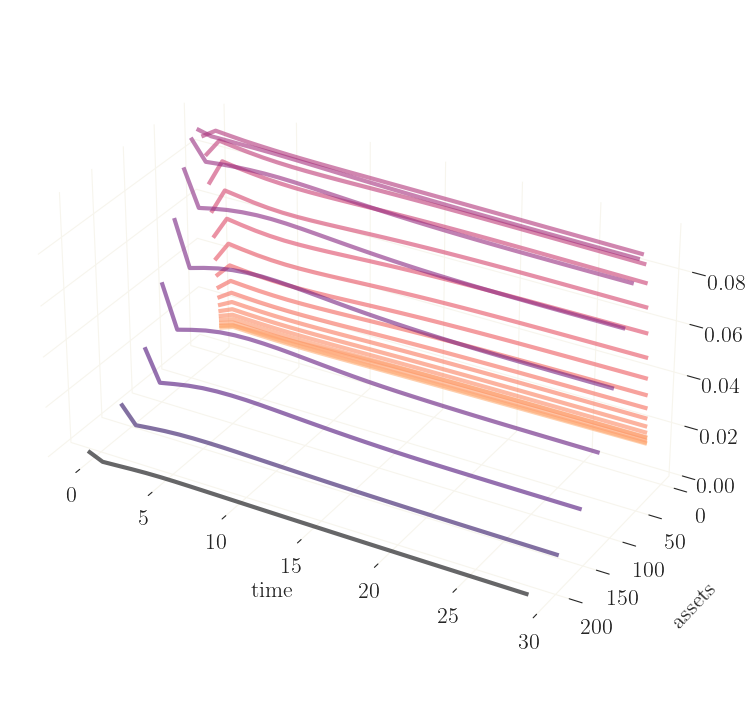

In [9]:
# get grids
a_grid = mod1['context']['a_grid']
b_grid = mod1['context']['b_grid']
e_grid = mod1['context']['skills_grid']

T = 30
# define main objects
het_vars = mod1.get_distributions(xst0, init_dist=dist0)
dist = het_vars['dist'][...,:T]
con = het_vars['c'][...,:T]
t_grid = jnp.arange(dist.shape[-1])
data = dist.sum((0,1))
grid = a_grid

# create color list
n = data.shape[0]
cgain = 1/2
X, Y = jnp.meshgrid(t_grid, grid)
clist = plt.cm.magma(jnp.linspace(.00,.85**(1/cgain),n)**cgain)[::-1]

# 3d plot
ax = plt.figure(figsize=(12,9)).add_subplot(projection='3d')
ax.plot_wireframe(X, Y, data, rstride=1, cstride=0, colors=clist, lw=3, alpha=.6) 
ax.invert_yaxis()
ax.set_xlabel('time', labelpad=15)
ax.set_ylabel('assets', labelpad=15)
ax.set_zlabel('share', labelpad=15)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_box_aspect(aspect=(2,1,1))

## Figure 4
More transition dynamics, but with ELB and DNWR.

In [10]:
# copy parameters and activate OCBs
pars1 = pars.copy()
pars2 = pars.copy()
pars1['elb'] = 1.
pars2['iota'] = .98

# simulate
xst1, _ = mod1.find_path(init_state=x0.values(), init_dist=dist0, pars=pars1, horizon=horizon)
xst2, _ = mod1.find_path(init_state=x0.values(), init_dist=dist0, pars=pars2, horizon=horizon)

(get_derivatives:) Derivatives calculation done (5.957s).
(get_jacobian:) Jacobian accumulation and decomposition done (7.966s).
    Iteration  1 | fev.  30 | error 6.91e+00 | inner 6.10e-01 | dampening 0.662
    Iteration  2 | fev.  42 | error 1.26e+00 | inner 2.28e-06 | dampening 1.000
    Iteration  3 | fev.  61 | error 3.72e-01 | inner 8.94e-06 | dampening 1.000
    Iteration  4 | fev.  91 | error 2.20e-01 | inner 3.38e-04 | dampening 1.000
    Iteration  5 | fev. 121 | error 2.60e-01 | inner 2.37e-03 | dampening 1.000
    Iteration  6 | fev. 151 | error 5.72e-02 | inner 2.98e-05 | dampening 1.000
    Iteration  7 | fev. 163 | error 5.62e-04 | inner 7.06e-06 | dampening 0.857
    Iteration  8 | fev. 177 | error 1.46e-05 | inner 9.50e-07 | dampening 1.000
    Iteration  9 | fev. 191 | error 1.16e-06 | inner 8.63e-08 | dampening 1.000
    Iteration 10 | fev. 205 | error 8.98e-08 | inner 7.23e-09 | dampening 1.000
    Iteration 11 | fev. 219 | error 6.89e-09 | inner 5.84e-10 | dampeni

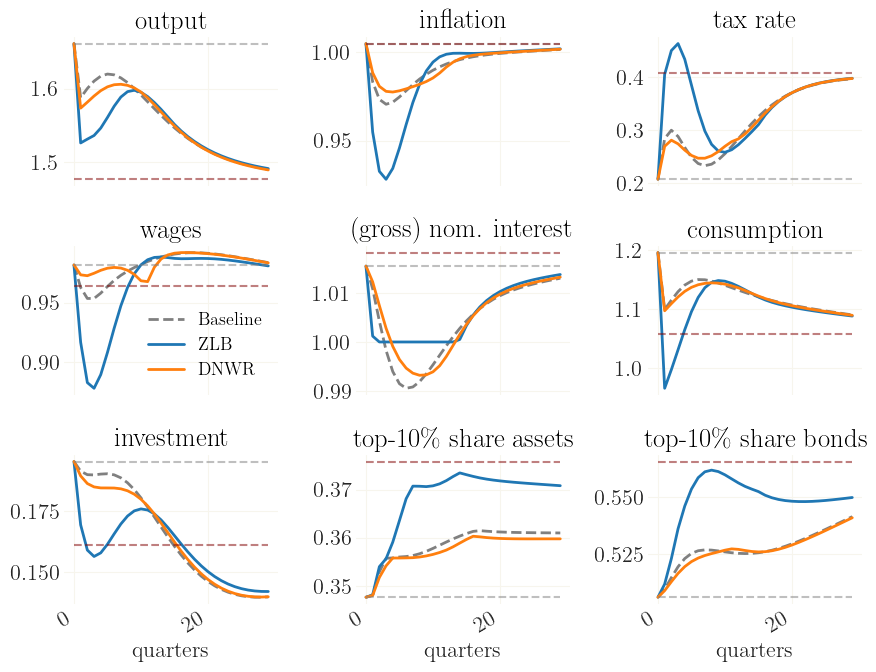

In [11]:
# choice of variables to plot
vlist = ['y', 'pi', 'tax', 'w', 'R', 'C', 'i', 'Top10A', 'Top10B']
vprint = ['output', 'inflation', 'tax rate', 'wages', '(gross) nom. interest', 'consumption', 'investment', 'top-10\\% share assets', 'top-10\\% share bonds']
vinds = [mod1.var_names.index(v) for v in vlist]

xsts = tuple(x[:30, vinds] for x in (xst0, xst1, xst2))

# plotting
figs, axs = figurator(3,3, figsize=(9,7))
pplot(xsts, labels=vprint, ax=axs, styles=('--', '-', '-'), colors=('gray', 'C0', 'C1'), legend=('Baseline', 'ZLB', 'DNWR'), lw=2)
[axs[i].set_xlabel('quarters') for i in (6,7,8)]
[axs[i].plot([mod0['stst'][v]]*30, ls='--', c='gray', alpha=.5) for i,v in enumerate(vlist)]
[axs[i].plot([mod1['stst'][v]]*30, ls='--', c='maroon', alpha=.5) for i,v in enumerate(vlist)]
axs[3].legend(framealpha=.0, fontsize=13)
figs[0].tight_layout()

## Figure 5
Transition dynamics, but only for transitory shock in a model without agregate state variables. 

If you are on econpizza version 0.6.8 and above, the model for this exercise is included in the examples. You can simply use:

In [12]:
# the model is also part of examples
file_name_nc = ep.examples.hank2_no_capital

# parsing, editing and loading model
mod_dict = ep.parse(file_name_nc)

# again use a larger grid
mod_dict['distributions']['dist']['b']['n'] = 20
mod_dict['distributions']['dist']['a']['n'] = 25
mod = ep.load(mod_dict, raise_errors=True)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...adding endogenous log-grid for 'b' named 'b_grid'.
    ...adding endogenous log-grid for 'a' named 'a_grid'.
(load:) Parsing done.


If you are on econpizza version 0.6.7 and below, you have to take the rocky road:

In [13]:
import requests
import tempfile
import os

url_yaml = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank2_no_capital.yml"
url_funcs = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank2_functions.py"

# download yaml
dl_yaml = requests.get(url_yaml)
dl_funcs = requests.get(url_funcs)

# write content to temporary directory
with tempfile.TemporaryDirectory() as tmpdirname:
    path_yaml = os.path.join(tmpdirname, 'model.yaml')
    path_funcs = os.path.join(tmpdirname, 'hank2_functions.py')

    with open(path_yaml, 'wb') as f:
        f.write(dl_yaml.content)

    with open(path_funcs, 'wb') as f:
        f.write(dl_funcs.content)

    # and parse the file that was just created
    mod_dict = ep.parse(path_yaml)

    # again use a larger grid
    mod_dict['distributions']['dist']['b']['n'] = 20
    mod_dict['distributions']['dist']['a']['n'] = 25
    mod = ep.load(mod_dict, raise_errors=True)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...adding endogenous log-grid for 'b' named 'b_grid'.
    ...adding endogenous log-grid for 'a' named 'a_grid'.
(load:) Parsing done.


In [14]:
# solve steady state
res_stst = mod.solve_stst(tol=1e-8)

(solve_stst:) Steady state found (8.4397s). The solution converged.


In [15]:
# adjust size of the shock to level of steady state values
x0 = mod['stst'].copy()
shocks = ('e_t',jnp.log(.05*x0['y']/x0['transfers']))

# get and set parameters
pars = ep.copy(mod['pars'])
pars['rho_r'] = .0
pars['rho'] = .0
pars['rho_t'] = .0
pars['rho_tax'] = .0

# simulate without debt financing
xst, flags = mod.find_path(shock=shocks, horizon=200, pars=pars)

# allow debt financing and simulate again
pars['rho_tax'] = .9
xst_debt, flags = mod.find_path(shock=shocks, horizon=200, pars=pars)

(get_derivatives:) Derivatives calculation done (8.449s).
(get_jacobian:) Jacobian accumulation and decomposition done (5.812s).
    Iteration  1 | fev.   1 | error 9.47e-01 | inner 3.87e-06 | dampening 1.000
    Iteration  2 | fev.  11 | error 4.26e-01 | inner 5.63e-06 | dampening 1.000
    Iteration  3 | fev.  21 | error 9.19e-02 | inner 8.15e-06 | dampening 1.000
    Iteration  4 | fev.  25 | error 1.04e-03 | inner 4.00e-06 | dampening 1.000
    Iteration  5 | fev.  28 | error 1.38e-06 | inner 1.11e-07 | dampening 0.988
    Iteration  6 | fev.  31 | error 4.49e-08 | inner 3.35e-09 | dampening 1.000
    Iteration  7 | fev.  34 | error 1.41e-09 | inner 1.05e-10 | dampening 1.000 | lapsed 3.1294s
(find_path:) Stacking done (31.202s). The solution converged.
(get_derivatives:) Derivatives calculation done (5.093s).
(get_jacobian:) Jacobian accumulation and decomposition done (5.502s).
    Iteration  1 | fev.   1 | error 8.63e-01 | inner 3.99e-06 | dampening 1.000
    Iteration  2 | fev.

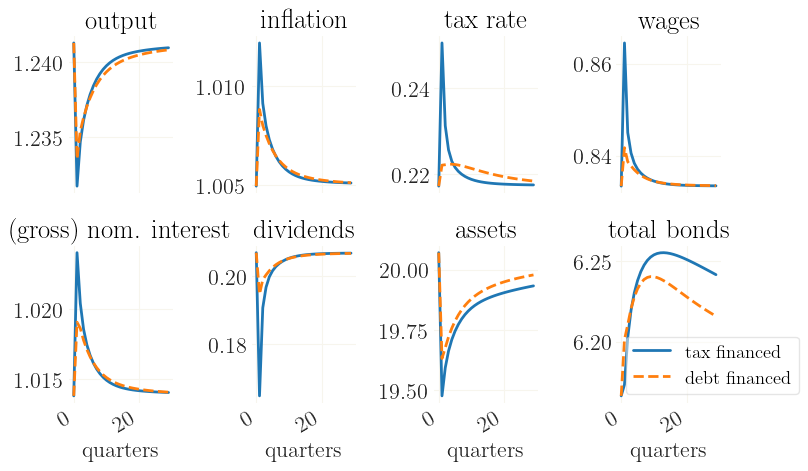

In [16]:
# decide what to plot
vlist = ['y', 'pi', 'tax', 'w', 'R', 'div', 'A', 'B']
vprint = ['output', 'inflation', 'tax rate', 'wages', '(gross) nom. interest', 'dividends', 'assets', 'total bonds']
vinds = [mod.variables.index(v) for v in vlist]

# plotting
figs, axs = figurator(2,4, figsize=(8,5))
pplot((xst[:30, vinds], xst_debt[:30, vinds]), labels=vprint, ax=axs, styles=('-', '--'), legend=('tax financed', 'debt financed'), lw=2)
axs[-1].legend()
[axs[i].set_xlabel('quarters') for i in (4,5,6,7)]
_ = [f.tight_layout() for f in figs]